<p align="center"><img src="https://raw.githubusercontent.com/Empa-Teknoloji/AI_Workshop/master/Additionals/Empa-Workshops-Template-Banner2.png" alt="Accelerator Workshops" style="display: block; margin: 0 auto" height=/></p>

# 1) Vitis-AI ile FPGA Platformlarında AI Uygulamaları Geliştirme
Empa Electronics tarafından düzenlenen Accelerators Workshops serimizin Uçta Yapay Zeka adımına hoşgeldiniz.  
Bu kılavuz, modern makine öğrenimi yaklaşımlarıyla geliştirilmiş bir yapay zeka/derin öğrenme çözümünün Vitis-AI geliştirme ortamı araçları kullanılarak FPGA tabanlı platformlara implementasyonu adımlarının deneyimlenmesinde size rehberlik edecektir.

Aktivite içeriği olan "Yolov5 derin öğrenme mimarisi ile nesne tespiti" uygulamasının adımları, AMD'nin Kria ürün serisine ait KV260 geliştirme kartı üzerinde adımlarla açıklanacaktır. Kullanılan model mimarisi, kart üzerindeki FPGA yapısı bloğu için AMD tarafından tasarlanmış DPU IP desteğiyle çalıştırılacak ve Vitis-AI ortamı araçları yardımıyla yapay zeka çözümü haline getirilecektir.

**Uygulama Adımları**

1- Modelin Değerlendirilmesi (Inspection)  

2- Vitis-AI DPU Desteği İçin Model Modifikasyonu  

3- Modifikasyon ve Eğitim Sonrası Model  

4- Modelin Doğrulanması (Inspection + Prediction)  

5- Modifikasyon Sonrası Gereksinimler

6- Post-processing ve Tahminlerin Eldesi

7- Model Quantization Adımı

8- Modelin Hedef Platform İçin Derlenmesi

## 1. Modelin Değerlendirilmesi

Gerekli modüllerin dahil edilmesi:

In [1]:
!pip install torchinfo

import torch
from torch import nn
from models.common import DetectMultiBackend
from PIL import Image
import cv2
import numpy as np

from utils.general import check_version, non_max_suppression

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.9/921.9 kB 5.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 6.4 MB/s eta 0:00:0000:0100:01


Matplotlib is building the font cache; this may take a moment.


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Hedef DPU mimari tanımlaması:

In [2]:
target_architecture = "DPUCZDX8G_ISA1_B4096"

Model Inspector aracının kullanımı için fonksiyon tanımlaması:

In [3]:
def inspect_model(model, device, image_shape, outdir):
    # import model inspector
    from pytorch_nndct import Inspector
    
    # define a dummy input
    c, h, w = image_shape
    input_dummy = torch.randn(1, c, w, h).to(device)
    device = torch.device(device)

    inspector = Inspector(target_architecture)
    inspector.inspect(model, (input_dummy,), device=device, output_dir=outdir, image_format="png")

## 2. Vitis-AI Desteği İçin Model Modifikasyonu

_Bu adımın gösterimi uygulamalı olarak yapılacaktır._

_1) Model yapısal değişikliklerinin oluşturulması._  
_2) Yapısal olarak değiştirilmiş modelin eğitimi._

## 3. Modifikasyon ve Eğitim Sonrası Model

Konfigürasyon için gerekli parametrelerin tanımlanması:

In [4]:
path_model = "/workspace/yolov5/yolov5s_epoch35.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = (540, 960)
IMG_CHANNELS = 3

Yeniden düzenlenmiş ve eğitilmiş modelin yüklenmesi:

In [5]:
def import_model(path_model, device_type):
    device = torch.device(device_type)
    model = DetectMultiBackend(weights=path_model, device=device)
    return model

In [6]:
model = import_model(path_model, device)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs


Model mimarisine bakış:

In [7]:
model

DetectMultiBackend(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): LeakyReLU(negative_slope=0.1015625, inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): LeakyReLU(negative_slope=0.1015625, inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): LeakyReLU(negative_slope=0.1015625, inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): LeakyReLU(negative_slope=0.1015625, inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): LeakyReLU(negative_slope=0.1015625, inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): C

## 4- Modelin Doğrulanması

Modelin tahmin ile testi için gerekli fonksiyonunun tanımlanması:

In [8]:
augment = False
visualize = False

def execute_model(model, img):

    from PIL import Image
    from torchvision.transforms import Compose, ToTensor, Resize

    transforms = Compose([
        ToTensor(),
        Resize(size=(540, 960)), 
    ])

    img = transforms(img)
    img = img.unsqueeze(0).cuda()

    pred = model(img, augment=augment, visualize = visualize)
    return pred

Modelin sonuçlarınının görselleştirilmesi için gerekli fonksiyonun tanımlanması:

In [9]:
def draw_bbox(image, preds_nms):
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    image = cv2.resize(image, (960, 540))
    
    for ind, pred in enumerate(preds_nms):
        topleft = (int(pred[0]), int(pred[1]))
        bottomright = (int(pred[2]), int(pred[3]))
        print(f"Object instance: {ind} | topleft: {topleft}, bottomright: {bottomright}")
        
        cv2.rectangle(image, topleft, bottomright, (255, 0, 0), 2)

    image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
    return image

Tahminleme için kullanılacak veri örneği:

In [10]:
img_original = Image.open("/workspace/yolov5/data/images/zidane.jpg")

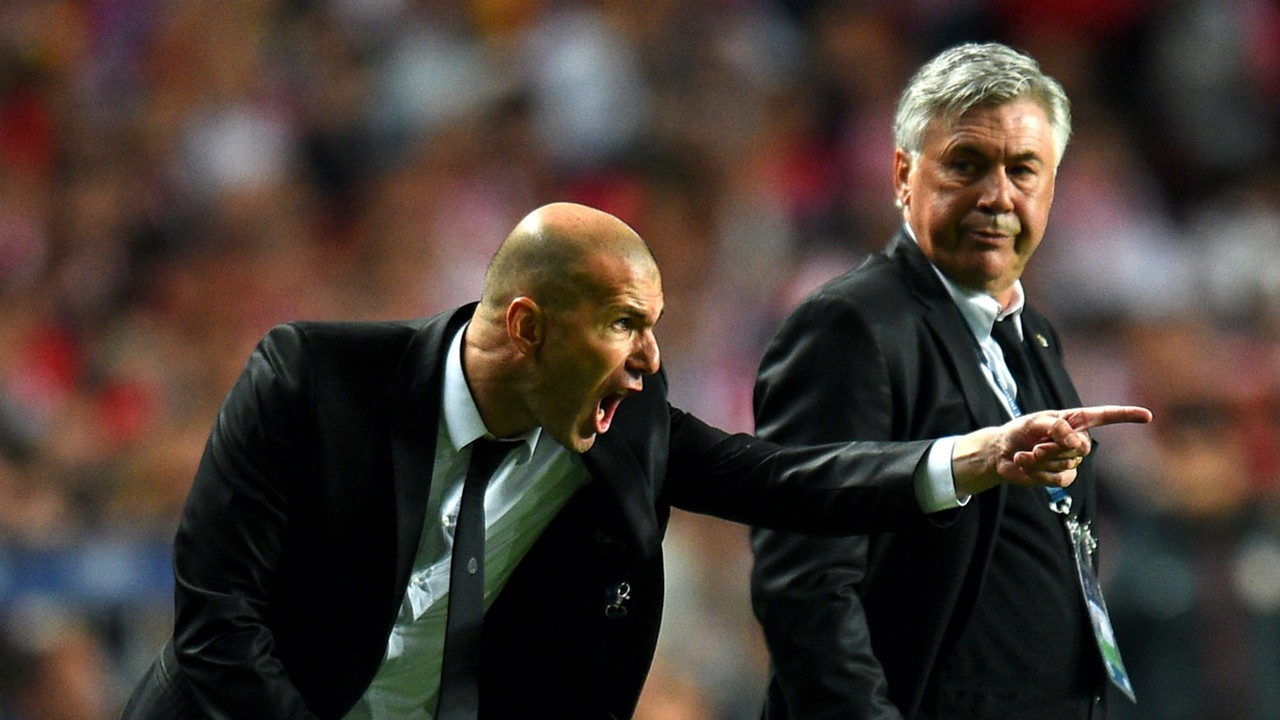

In [11]:
img_original

Modelin mevcut haliyle çıktı formatına bakış:

In [12]:
# predict an image sample using the trained model 
predictions_float = execute_model(model, img_original)
# preds_test = postprocessing(pred_raw_plain, model_test)

print(f"Number of elements: {len(predictions_float)}")
print(predictions_float[0].shape, predictions_float[1].shape, predictions_float[2].shape, sep="\n")

Number of elements: 3
torch.Size([1, 255, 68, 120])
torch.Size([1, 255, 34, 60])
torch.Size([1, 255, 17, 30])


Modelin mevcut haliyle DPU uyumluluğunun kontrolü:

In [13]:
inspect_model(model, device, (IMG_CHANNELS, IMG_SIZE[0], IMG_SIZE[1]), 
              outdir="/workspace/yolov5/Vitis-AI-Experiment/inspection_results_modified")


[VAIQ_NOTE]: Loading NNDCT kernels...

[VAIQ_NOTE]: Inspector is on.

[VAIQ_NOTE]: =>Start to inspect model...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing DetectMultiBackend...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]: The input model nndct_st_DetectMultiBackend_ed is torch.nn.Module.

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 144/144 [00:00<00:00, 709.10it/s, OpInfo: name = return_0, type = Return]                                                                                                                 



[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_WARN][QUANTIZER_TORCH_LEAKYRELU]: Preserve negative_slope(0.1015625) of LeakyReLU without quantization.

[VAIQ_NOTE]: =>Quantizable module is generated.(/workspace/yolov5/Vitis-AI-Experiment/inspection_results_modified/DetectMultiBackend.py)

[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Conv[model]/Conv[7]/Conv2d[conv]/ret.71, op type:nndct_conv2d, output shape: [1, 30, 17, 512]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Conv[model]/Conv[7]/LeakyReLU[act]/10491, op type:nndct_leaky_relu, output shape: [1, 30, 17, 512]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[13]/Conv[cv3]/Conv2d[conv]/ret.109, op type:nndct_conv2d, output shape: [1, 60, 34, 256]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[13]/Conv[cv3]

I20250227 02:05:08.816177  1975 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20250227 02:05:08.816197  1975 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20250227 02:05:08.816206  1975 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20250227 02:05:08.816262  1975 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_leaky_relu_NY6QOByjo8vLcfn9, with op num: 9
I20250227 02:05:08.816298  1975 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20250227 02:05:08.876083  1975 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20250227 02:05:08.876116  1975 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20250227 02:05:08.880295  1975 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20250227 02:05:08.880312  1975 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20250227 02:05:08.880338  1975 


[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[6]/Sequential[m]/Bottleneck[0]/Conv[cv2]/Conv2d[conv]/ret.49, op type:nndct_conv2d, output shape: [1, 60, 34, 128]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[6]/Sequential[m]/Bottleneck[0]/Conv[cv2]/LeakyReLU[act]/10324, op type:nndct_leaky_relu, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[23]/Conv[cv3]/Conv2d[conv]/ret.159, op type:nndct_conv2d, output shape: [1, 30, 17, 512]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[23]/Conv[cv3]/LeakyReLU[act]/11276, op type:nndct_leaky_relu, output shape: [1, 30, 17, 512]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[20]/Conv[cv2

I20250227 02:05:09.078065  1975 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20250227 02:05:09.078070  1975 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20250227 02:05:09.078131  1975 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_leaky_relu_d1ZW7Rmw4uYkncIU, with op num: 9
I20250227 02:05:09.078136  1975 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20250227 02:05:09.092738  1975 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20250227 02:05:09.092782  1975 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20250227 02:05:09.097918  1975 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20250227 02:05:09.097939  1975 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20250227 02:05:09.097944  1975 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I2025022


[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/Sequential[m]/Bottleneck[1]/Conv[cv2]/Conv2d[conv]/ret.33, op type:nndct_conv2d, output shape: [1, 120, 68, 64]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/Sequential[m]/Bottleneck[1]/Conv[cv2]/LeakyReLU[act]/10185, op type:nndct_leaky_relu, output shape: [1, 120, 68, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[2]/Conv[cv2]/Conv2d[conv]/ret.15, op type:nndct_conv2d, output shape: [1, 240, 135, 32]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[2]/Conv[cv2]/LeakyReLU[act]/10024, op type:nndct_leaky_relu, output shape: [1, 240, 135, 32]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Conv[model]/Conv[21]/Conv2

I20250227 02:05:09.299705  1975 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20250227 02:05:09.299731  1975 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20250227 02:05:09.299737  1975 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20250227 02:05:09.299820  1975 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_leaky_relu_HCbYxfrpouA5UB3G, with op num: 9
I20250227 02:05:09.299829  1975 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20250227 02:05:09.308600  1975 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20250227 02:05:09.308633  1975 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20250227 02:05:09.313720  1975 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20250227 02:05:09.313737  1975 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20250227 02:05:09.313742  1975 


[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Conv[model]/Conv[1]/Conv2d[conv]/ret.5, op type:nndct_conv2d, output shape: [1, 240, 135, 64]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Conv[model]/Conv[1]/LeakyReLU[act]/9933, op type:nndct_leaky_relu, output shape: [1, 240, 135, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[2]/Conv[cv1]/Conv2d[conv]/ret.7, op type:nndct_conv2d, output shape: [1, 240, 135, 32]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[2]/Conv[cv1]/LeakyReLU[act]/9955, op type:nndct_leaky_relu, output shape: [1, 240, 135, 32]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[23]/Sequential[m]/Bottleneck[0]/Conv[cv2]/Conv2d[conv]/ret.153, op type:nndct_conv2

I20250227 02:05:09.507648  1975 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20250227 02:05:09.507668  1975 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20250227 02:05:09.507673  1975 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20250227 02:05:09.507777  1975 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_leaky_relu_LyNgZA6j5nJdpUh2, with op num: 9
I20250227 02:05:09.507783  1975 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20250227 02:05:09.514173  1975 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20250227 02:05:09.514205  1975 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20250227 02:05:09.520929  1975 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20250227 02:05:09.520949  1975 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20250227 02:05:09.520954  1975 


[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[13]/Sequential[m]/Bottleneck[0]/Conv[cv2]/Conv2d[conv]/ret.103, op type:nndct_conv2d, output shape: [1, 60, 34, 128]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[13]/Sequential[m]/Bottleneck[0]/Conv[cv2]/LeakyReLU[act]/10802, op type:nndct_leaky_relu, output shape: [1, 60, 34, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/SPPF[model]/SPPF[9]/Conv[cv2]/Conv2d[conv]/ret.91, op type:nndct_conv2d, output shape: [1, 30, 17, 512]
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/SPPF[model]/SPPF[9]/Conv[cv2]/LeakyReLU[act]/10704, op type:nndct_leaky_relu, output shape: [1, 30, 17, 512]



[VAIQ_NOTE]: Find subgraph for convlike_fix_18:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Conv[model]/Conv[

I20250227 02:05:09.713590  1975 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20250227 02:05:09.713594  1975 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20250227 02:05:09.713647  1975 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_nndct_leaky_relu_4VBgDGjul56WQakh, with op num: 9
I20250227 02:05:09.713652  1975 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20250227 02:05:09.731719  1975 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20250227 02:05:09.731747  1975 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20250227 02:05:09.736908  1975 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20250227 02:05:09.736925  1975 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20250227 02:05:09.736930  1975 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I2025022


[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/Concat[model]/Concat[22]/ret.147, op type:nndct_concat, output shape: [1, 30, 17, 512]



[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/SPPF[model]/SPPF[9]/ret.89, op type:nndct_concat, output shape: [1, 30, 17, 1024]



[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[8]/ret.83, op type:nndct_concat, output shape: [1, 30, 17, 512]



[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[4]/ret.39, op type:nndct_concat, output shape: [1, 120, 68, 128]



[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:DetectMultiBackend::DetectMultiBackend/DetectionModel[model]/C3[model]/C3[20]/ret.141, op type:nndct_concat, output shape: [1, 60, 34, 256]

I20250227 02:05:09.936388  1975 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20250227 02:05:09.936403  1975 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20250227 02:05:09.936408  1975 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20250227 02:05:09.936466  1975 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_concat_Bm930I2tpqy4sc8i, with op num: 6
I20250227 02:05:09.936472  1975 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20250227 02:05:09.941054  1975 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 4, DPU subgraph number 1
I20250227 02:05:09.941105  1975 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20250227 02:05:09.946010  1975 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20250227 02:05:09.946036  1975 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20250227 02:05:09.946045  1975 compile_pass_mana


[VAIQ_NOTE]: Dot image is generated.(/workspace/yolov5/Vitis-AI-Experiment/inspection_results_modified/inspect_DPUCZDX8G_ISA1_B4096.png)

[VAIQ_NOTE]: =>Finish inspecting.


In [ ]:
torch.save(model, "/workspace/yolov5/Vitis-AI-Experiment/model_float/model_yolov5s_modified.pt")

## 5. Modifikasyon Sonrası Gereksinimler

Modelin düzenlenmesi sırasından model yapısından çıkarılan adımların farklı platformda (CPU) yürütülebilmesi için gerekli fonksiyonların tanımlanması:

In [15]:
from utils.general import check_version, non_max_suppression

In [16]:
def get_model_attr(model):
    head = model.model.model[-1]
    nl = head.nl
    na = head.na
    no = head.no
    nc = head.nc
    dynamic = head.dynamic
    grid = head.grid
    anchor_grid = head.anchor_grid
    stride = head.stride
    anchors = head.anchors
    return [nl, na, no, nc], [dynamic, anchors, stride, grid, anchor_grid]

def write_model_attr(model, name):
    head = model.model.model[-1]
    dict_attr = dict()
    dict_attr['nl'] = head.nl
    dict_attr['na'] = head.na
    dict_attr['no'] = head.no
    dict_attr['nc'] = head.nc
    dict_attr['dynamic'] = head.dynamic
    dict_attr['grid'] = head.grid
    dict_attr['anchor_grid'] = head.anchor_grid
    dict_attr['stride'] = head.stride
    dict_attr['anchors'] = head.anchors

    torch.save(dict_attr, f"{name}.attributes")

def read_model_attr(path_attributes):
    dict_attr = torch.load(path_attributes)
    return [dict_attr['nl'], dict_attr['na'], dict_attr['no'], dict_attr['nc']], [dict_attr['dynamic'], dict_attr['anchors'], dict_attr['stride'], dict_attr['grid'], dict_attr['anchor_grid']]


def _make_grid(nx=20, ny=20, i=0, torch_1_10=check_version(torch.__version__, "1.10.0"), na=None, anchors=None, stride=None):
        d = anchors[i].device
        t = anchors[i].dtype
        shape = 1, na, ny, nx, 2  # grid shape
        y, x = torch.arange(ny, device=d, dtype=t), torch.arange(nx, device=d, dtype=t)
        yv, xv = (torch.meshgrid(y, x, indexing="ij") if torch_1_10 else torch.meshgrid(y, x))  # torch>=0.7 compatibility
        grid = (torch.stack((xv, yv), 2).expand(shape) - 0.5).float()  # add grid offset, i.e. y = 2.0 * x - 0.5
        anchor_grid = ((anchors[i].clone() * stride[i]).view((1, na, 1, 1, 2)).expand(shape)).float()
        return grid, anchor_grid

def postprocessing(x, model):

    [nl, na, no, nc], [dynamic, anchors, stride, grid, anchor_grid] = get_model_attr(model)

    z = []  # inference output
    for i in range(nl):
        # print(x[i].shape)
        bs, _, ny, nx = x[i].shape  # x(bs,255,20,20) to x(bs,3,20,20,85)
        # print("ny, nx:", ny, nx, bs)
        x[i] = x[i].view(bs, na, no, ny, nx).permute(0, 1, 3, 4, 2).contiguous()

        if dynamic or grid[i].shape[2:4] != x[i].shape[2:4]:
            grid[i], anchor_grid[i] = _make_grid(nx, ny, i, na=na, anchors=anchors, stride=stride)

        # Detect (boxes only)
        xy, wh, conf = x[i].sigmoid().split((2, 2, nc + 1), 4)
        xy = (xy * 2 + grid[i]) * stride[i]  # xy
        wh = (wh * 2) ** 2 * anchor_grid[i]  # wh
        y = torch.cat((xy, wh, conf), 4)
        z.append(y.view(bs, na * nx * ny, no))

    return (torch.cat(z, 1), x)

## 6. Post-processing ve Tahminlerin Eldesi

Ham tahminlerin elde edilmesi:

In [17]:
# ham tahminlerin elde
predictions_float = execute_model(model, img_original)

YOLO mimarisi standart postprocessing adımlarının uygulanması:

In [18]:
predictions_float_processed = postprocessing(predictions_float, model)

Non-maximum Suppression filtresinin uygulanması:

In [19]:
conf_thres=0.15     # confidence threshold
iou_thres=0.25
classes=None        # filter by class: --class 0, or --class 0 2 3
agnostic_nms=False
max_det=1000 

predictions_float_nms = non_max_suppression(predictions_float_processed, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

Object instance: 0 | topleft: (322, 326), bottomright: (387, 541)
Object instance: 1 | topleft: (548, 31), bottomright: (880, 550)
Object instance: 2 | topleft: (59, 146), bottomright: (666, 538)
Object instance: 3 | topleft: (740, 225), bottomright: (770, 319)


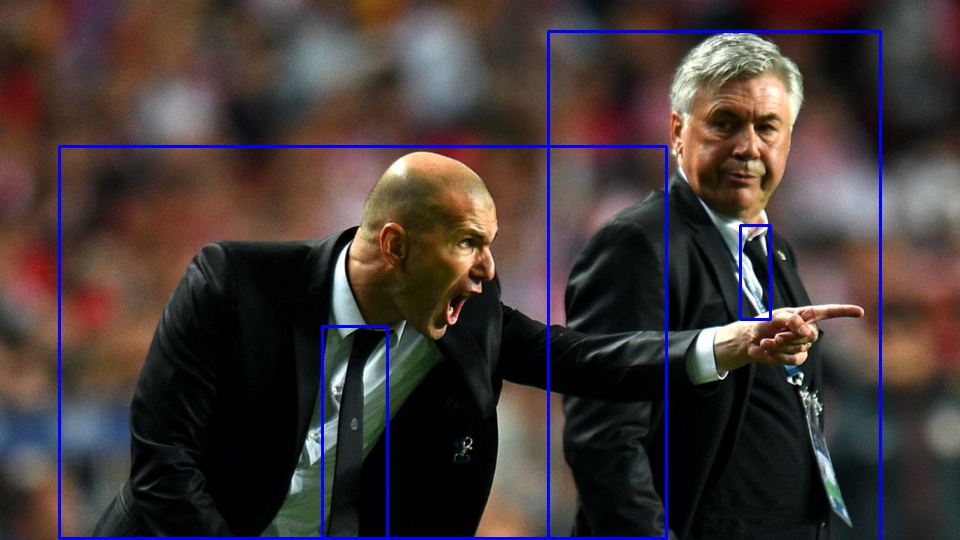

In [20]:
img_temp1 = draw_bbox(img_original, predictions_float_nms[0])
Image.fromarray(img_temp1)

## 7. Model Quantization Adımı 

Quantization için gerekli modüller:

In [21]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from random import shuffle, choices
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from utils.general import non_max_suppression

Kalibrasyon veri setinin yüklenmesi:  

_Kalibrasyon veri setinin, idealde eğitim veri setinden alınan ve etiketlere ihtiyaç olmaksızın edinilmiş yaklaşık 1000 adet veri örneğinden oluşturulması önerilmektedir._ 

In [22]:
path_dataset_calib = "/workspace/INPUTS/imagenet-samples/"

transforms_calib = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE[0], IMG_SIZE[1]))
])

class CalibrationDatasetCreator(Dataset):
    def __init__(self, path_calib_root, transforms, stability_check=True):
        self.path_calib_root = Path(path_calib_root)
        self.transforms = transforms
        self.list_image_paths = list(self.path_calib_root.rglob("*JPEG"))
        if stability_check:
            self.list_image_paths = [path for path in self.list_image_paths if np.array(Image.open(str(path))).shape[-1] == 3]

    def __len__(self):
        return len(self.list_image_paths)

    def __getitem__(self, ind):
        path_image = str(self.list_image_paths[ind])
        image = Image.open(path_image)
        if self.transforms:
            image = self.transforms(image)
        return image
    
dataset_calib = CalibrationDatasetCreator(path_dataset_calib, transforms_calib)

In [23]:
def print_shapes(dataset, label_exist=True):
    print("validation dataset size:", len(dataset))
    for data in dataset:
        if label_exist: 
            x,y = data
        else:
            x = data
        print("sample shape:\n\t", x.shape)
        if label_exist:
            print("label shape:\n\t", len(y))
        break

In [24]:
print_shapes(dataset_calib, label_exist=False)

validation dataset size: 977
sample shape:
	 torch.Size([3, 540, 960])


Kuantalama işlemi içerisinde gerekli olan forward-pass işlemi ve metrik ölçümü amacıyla oluşturulan foksiyon: 

In [25]:
def evaluate_model(model_instance, dataset, device, batch=None):

    model_instance.eval()

    if batch:
        dataloader = DataLoader(dataset, batch_size=batch, shuffle=True)

    with torch.no_grad():
        for data in dataloader:
            if isinstance(data, (list, tuple)):
                X, y = data
                y = y.to(device)
            elif isinstance(data, torch.Tensor):
                X = data
            else: 
                raise TypeError
        
            X = X.to(device)
            outs = model_instance(X)
            preds = non_max_suppression(outs)

Vitis-AI Quantizer için mod seçimi parametreleri:

In [28]:
batch_size = 1
quant_mode = "test"

Kuantalama adımları:

- Vitis-AI Quantizerın kullanımı esnasında ilk önce, aracın "calib" ile çalıştırılması ve veri temelli istatistiklerin kayıt edilmesi gerekmektedir.
- Ardından aracın "test" modunda batch_size=1 ile çalıştırılması ile kuantalama işleminden geçirilen modelin kayıt işlemi gerçekleştirilebilmektedir. 

In [27]:
# Step-1) importing the pytorch quantizer
from pytorch_nndct.apis import torch_quantizer

# set batch_size to 1 when 'test' is selected
if quant_mode == 'test':
    batch_size = 1

# Step-2) create quantizer object instance with given input
input_calib = torch.randn([batch_size, 3, 640, 640])
quantizer = torch_quantizer(quant_mode=quant_mode, 
                            module=model, 
                            input_args=(input_calib),
                            output_dir="/workspace/yolov5/Vitis-AI-Experiment/model_quantized")
print("Quantizer is defined.")

# Step-3) get the converted model to forward the model using calibration subset
model_quantized = quantizer.quant_model
print("Quantized model is created.")

# Step-4) organize model evaluation function and dataset & forward-pass the model using eval. func.
# if quant_mode == 'calib':
evaluate_model(model_quantized, dataset_calib, device, batch=batch_size)
print("Evaluation func. is called.")

# Step-5) export calibration configs first
if quant_mode == 'calib':
    quantizer.export_quant_config()

# Step-6) export quantized model
if quant_mode == 'test':
    quantizer.export_xmodel(deploy_check=False, output_dir="/workspace/yolov5/Vitis-AI-Experiment/model_quantized")
    print("Quantized xmodel file is saved.")


[VAIQ_NOTE]: OS and CPU information:
               system --- Linux
                 node --- Empa-Dell-G15
              release --- 6.8.0-52-generic
              version --- #53~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Jan 15 19:18:46 UTC 2
              machine --- x86_64
            processor --- x86_64

[VAIQ_NOTE]: Tools version information:
                  GCC --- GCC 7.5.0
               python --- 3.8.6
              pytorch --- 1.13.1+cu117
        vai_q_pytorch --- 3.5.0+60df3f1+torch1.13.1+cu117

[VAIQ_NOTE]: GPU information:
          device name --- NVIDIA GeForce RTX 3060 Laptop GPU
     device available --- True
         device count --- 1
       current device --- 0

[VAIQ_NOTE]: Quant config file is empty, use default quant configuration

[VAIQ_NOTE]: Quantization calibration process start up...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing DetectMultiBackend...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]: The input model nndc

██████████████████████████████████████████████████| 144/144 [00:00<00:00, 699.29it/s, OpInfo: name = return_0, type = Return]                                                                                                                



[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(/workspace/yolov5/Vitis-AI-Experiment/model_quantized/DetectMultiBackend.py)
Quantizer is defined.

[VAIQ_NOTE]: =>Get module with quantization.
Quantized model is created.

[VAIQ_WARN]: The shape of input (torch.Size([3, 540, 960])) should be the same with that of dummy input ([3, 640, 640])


/opt/vitis_ai/conda/envs/vitis-ai-pytorch/lib/python3.8/site-packages/pytorch_nndct/quantization/torchquantizer.py:223: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  bnfp[1] = stats.mode(data)[0][0]


Evaluation func. is called.

[VAIQ_NOTE]: =>Exporting quant config.(/workspace/yolov5/Vitis-AI-Experiment/model_quantized/quant_info.json)


Nicelenmiş modele yeniden bakış:

In [30]:
model_quantized.inner_model

DetectMultiBackend(
  (module_0): deephi_Input()
  (module_1): deephi_Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
  (module_2): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
  (module_3): deephi_Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (module_4): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
  (module_5): deephi_Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (module_6): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
  (module_7): deephi_Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (module_8): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
  (module_9): deephi_Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (module_10): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
  (module_11): deephi_Add()
  (module_12): deephi_Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (module_13): deephi_LeakyReLU(negative_slope=0.1015625, inplace=True)
  (module_14): deephi

Nicelenmiş model ile tahminlerin eldesi ve doğrulama:

Object instance: 0 | topleft: (551, 23), bottomright: (884, 553)
Object instance: 1 | topleft: (14, 25), bottomright: (593, 530)
Object instance: 2 | topleft: (327, 319), bottomright: (386, 538)


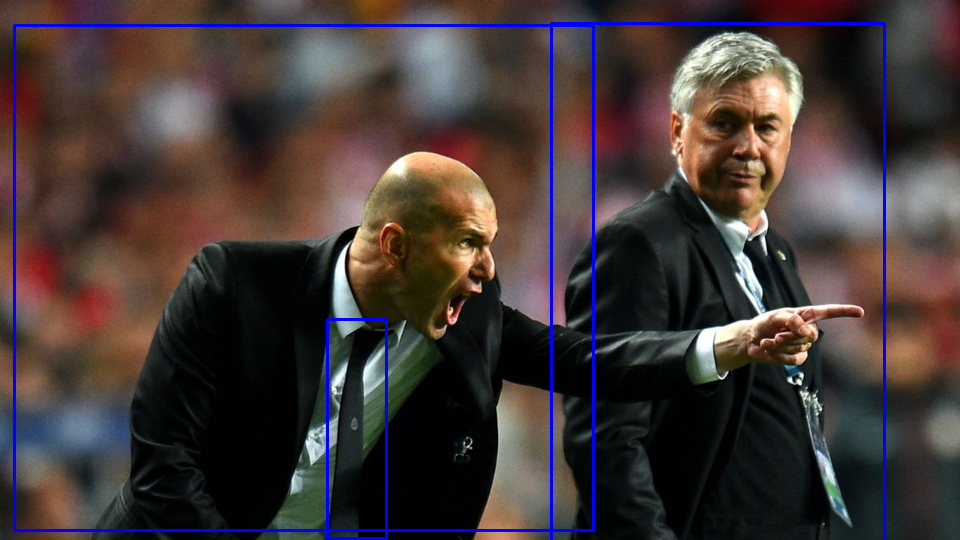

In [31]:
# ham tahminlerin elde
predictions_int8 = execute_model(model_quantized.inner_model, img_original)
predictions_int8_processed = postprocessing(list(predictions_int8), model)

conf_thres=0.15     # confidence threshold
iou_thres=0.25
classes=None        # filter by class
agnostic_nms=False
max_det=1000 
predictions_float_nms = non_max_suppression(predictions_int8_processed, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

img_temp1 = draw_bbox(img_original, predictions_float_nms[0])
Image.fromarray(img_temp1)

## 8. Modelin Hedef Platform İçin Derlenmesi 

Derleme için gerekli Vitis-AI modüllerinin dahil edilmesi:

In [32]:
from vaic.xcompiler_interface import xcompiler
import json

Derleme için gerekli konfigürasyon değişkenleri:

In [33]:
xmodel_path = "/workspace/yolov5/Vitis-AI-Experiment/model_quantized/DetectMultiBackend_int.xmodel"
arch_name = "DPUCZDX8G"
target_name = "KV260"
path_arch = f"/opt/vitis_ai/compiler/arch/{arch_name}/{target_name}/arch.json"
net_name = "YoloV5s_workshop"
output_dir_name = "model_compiled"

Derleme işlemi için kod adımları:

In [34]:
# define compiler parameters dictionary
compiler_params = {
	'parser': 'xir',
	'xmodel': str(xmodel_path),
	'net_name': net_name,
	'output_dir': 'Vitis-AI-Experiment/'+str(output_dir_name)
        }

# read arch fingerprint using arch.json
with open(path_arch) as json_data:
	if json_data: arch_data = json.load(json_data)

# add arch fingerprint to parameters dictionary
if arch_data and 'target' in arch_data:
	compiler_params['target'] = arch_data['target']
elif arch_data and 'fingerprint' in arch_data:
	compiler_params['fingerprint'] = arch_data['fingerprint']

# execute compiling process
xcompiler(compiler_params).compile()

[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: null
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
[UNILOG][INFO] Graph name: DetectMultiBackend, with op num: 448
[UNILOG][INFO] Begin to compile...
[UNILOG][INFO] Total device subgraph number 5, DPU subgraph number 1
[UNILOG][INFO] Compile done.
[UNILOG][INFO] The meta json is saved to "/workspace/yolov5/Vitis-AI-Experiment/model_compiled/meta.json"
[UNILOG][INFO] The compiled xmodel is saved to "/workspace/yolov5/Vitis-AI-Experiment/model_compiled/YoloV5s_workshop.xmodel"
[UNILOG][INFO] The compiled xmodel's md5sum is 6e3a4073336a8aa05ade04afe2d77654, and has been saved to "/workspace/yolov5/Vitis-AI-Experiment/model_compiled/md5sum.txt"
